In [1]:
import pandas as pd
import os
import bids
from tqdm import tqdm
import seaborn as sns
import sys
import shutil

In [2]:
uname = os.environ.get('USER')

if uname == 'emil':
    projdir = '/Users/emil/Projects/QA/CaliberPaper/lunarc/QA_paper/project'
elif uname == 'em2876lj':
    projdir = '/home/em2876lj/Projects/QA/QA_paper/project'

subses = pd.read_csv(os.path.join(projdir, 'code', 'slurm', 'all_sessions.txt'), delimiter=' ', names=['Subject', 'Session'])
layout = bids.BIDSLayout(root=projdir+'/rawdata', derivatives=projdir+'/derivatives')

OperationalError: (sqlite3.OperationalError) database or disk is full
[SQL: SELECT files.path AS files_path, files.filename AS files_filename, files.dirname AS files_dirname, files.is_dir AS files_is_dir, files.class_ AS files_class_ 
FROM files 
WHERE files.is_dir = 0 GROUP BY files.path]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
layout.get(scope='')

In [20]:
all_rows = []
for i,row in tqdm(subses.iterrows()):

    for orient in ['sag', 'cor', 'axi']:
        runs = [1,2] if orient == 'axi' else [None]

        for run in runs:
            try:
                f = layout.get(scope='derivatives', subject=row.Subject, 
                            session=row.Session, extension='.csv', run=run, 
                            reconstruction=orient, desc=f'FidPos')[0]
                
                df = pd.read_csv(f).drop(columns=['Unnamed: 0'])
                
                df['Axis'] = orient
                df['Run'] = run if orient == 'axi' else 1
                df['Subject'] = row.Subject
                df['Session'] = row.Session

                all_rows.append(df)

            except IndexError:
                continue

244it [00:37,  6.56it/s]


In [21]:
df = pd.concat(all_rows, ignore_index=True)

<Axes: xlabel='X', ylabel='Y'>

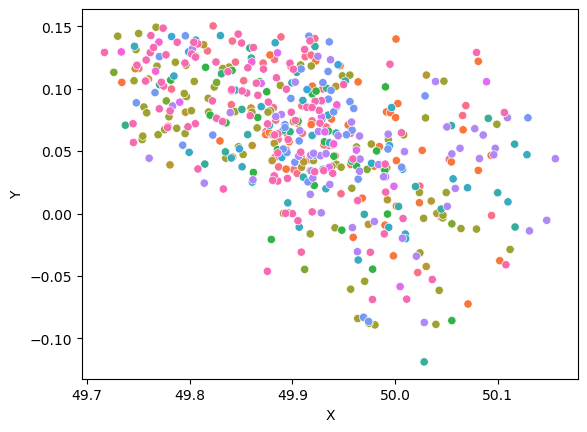

In [39]:
sns.scatterplot(data=df[(df['Axis']=='axi') & (df['label']==9)], x='X', y='Y', hue='Subject', legend=False)


In [26]:
df.dtypes

label        int64
X          float64
Y          float64
Z          float64
refX       float64
refY       float64
refZ       float64
diffX      float64
diffY      float64
diffZ      float64
Axis        object
Run          int64
Subject     object
Session     object
dtype: object